In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import openmc_source_plotter

In [2]:
#Lupin materials

#lead casing
lead = openmc.Material(name='lead')
lead.add_element('Pb', 1, 'ao')
#aluminium shell
al = openmc.Material(name='aluminium')
al.add_element('Al', 1, 'ao')
#cadmium 
cadmium = openmc.Material(name='cadmium')
cadmium.add_element('Cd', 1, 'ao')
#BF3
bf3 = openmc.Material(name='bf3')
bf3.add_elements_from_formula('BF3')
bf3.set_density('g/cm3', 0.00276)
#polyethylene
polyethylene = openmc.Material(name='polyethylene')
polyethylene.add_elements_from_formula('C2H4')
polyethylene.set_density('kg/m3',940)

materials = openmc.Materials([lead, al, cadmium, bf3, polyethylene])
materials.export_to_xml()

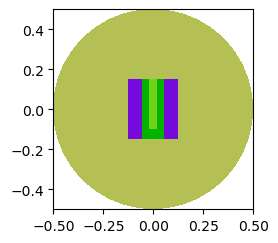

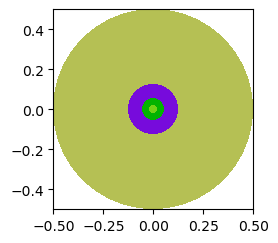

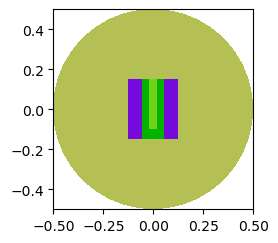

In [11]:
#lupin geometry
cylinder_radius = 0.054
detector_radius = 0.0215
detector_height = 0.047
cylinder_height = 0.297
shielding_thickness = 0.0015
outer_cylinder_radius = 0.125
lead_thickness = 0.0001
lead_height = 0.141

big_cd_height = 0.05
small_cd_height = 0.025
cd_thickness = 0.00005
cd_gap = 0.02425


outer_sphere = openmc.Sphere(r=0.5, boundary_type='vacuum')
outer_cylinder = openmc.ZCylinder(r=outer_cylinder_radius)
inner_cylinder = openmc.ZCylinder(r=cylinder_radius)
detector = openmc.ZCylinder(r=detector_radius)

top_cylinder = openmc.ZPlane(z0=0.5*cylinder_height)
bottom_cylinder = openmc.ZPlane(z0=-0.5*cylinder_height)
bottom_detector = openmc.ZPlane(z0=-0.5*cylinder_height+detector_height)

source_region = -outer_sphere &((+top_cylinder)  |  ( -bottom_cylinder) | (+outer_cylinder))
source_cell = openmc.Cell(region=source_region)

outer_poly_region = -outer_cylinder & +inner_cylinder & +bottom_cylinder & -top_cylinder
outer_poly_cell = openmc.Cell(region=outer_poly_region)

inner_poly_region = (-inner_cylinder & +detector & -top_cylinder & +bottom_cylinder) | (-bottom_detector & -detector)
inner_poly_cell = openmc.Cell(region=inner_poly_region)

detector_region = -detector & +bottom_detector & -top_cylinder
detector_cell = openmc.Cell(region=detector_region)

universe = openmc.Universe(cells=[source_cell,outer_poly_cell, inner_poly_cell, detector_cell])

x,y = 1,1
"""color_assignment = {detector_cell : 'blue',
                    shielding_cell : 'grey',
                    inner_poly_cell : 'green',
                    cd_cell : 'orange',
                    lead_cell : 'black',
                    outer_poly_cell :'limegreen',
                   source_cell : 'black'}"""
plt.show(universe.plot(width=(x, y), basis='xz'))
plt.show(universe.plot(width=(x, y), basis='xy'))
plt.show(universe.plot(width=(x, y), basis='yz'))

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

In [12]:
# makes the 3d "cube" style geometry
vox_plot = openmc.Plot()
vox_plot.type = 'voxel'
vox_plot.width = (1,1,1)
vox_plot.pixels = (300,300,300)
vox_plot.filename = 'plot_lupin'
vox_plot.color_by = 'material'
# vox_plot.colors = {copper: 'blue'}  # materials can be coloured using this command
plots = openmc.Plots([vox_plot])
plots.export_to_xml()

openmc.plot_geometry()
import os
os.system('openmc-voxel-to-vtk plot_lupin.h5 -o plot_lupin.vti')

from IPython.display import FileLink
display(FileLink('plot_lupin.vti'))

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/tasks/LUPIN/plot_lupin.vti

In [4]:
#now create the source
#spherical source enclosing the detector
sett = openmc.Settings()
sett.particles = 10000
sett.batches = 5
sett.inactive = 0
sett.run_mode = 'fixed source'

sphere_source = openmc.Source()

phi_angle = openmc.stats.Uniform(a=0., b= 2*3.14159265359)
theta_angle = openmc.stats.Uniform(a=0., b= 2*3.14159265359)
source_distance = radius = openmc.stats.Discrete([-0.5, 0.5], [0.5,0.5]) #m away from the lupin detector

sphere_source.particle = 'neutron'
sphere_source.energy = openmc.stats.Discrete([14e6],[1])
sphere_source.angle = openmc.stats.Isotropic()
sphere_source.space = openmc.stats.SphericalIndependent(source_distance, theta_angle, phi_angle, origin=(0.0, 0.0, 0.0))

#sphere_source.plot_source_position()

In [5]:
#now create a tally to calibrate the detector
tallies = openmc.Tallies()
neutron_particle_filter = openmc.ParticleFilter(['neutron'])

energy_filter = openmc.EnergyFilter(np.linspace(0,15e6,200))
detector_cell_filter = openmc.CellFilter(detector_cell)
detector_tally = openmc.Tally()
detector_tally.scores = ['flux']
detector_tally.filters = [detector_cell_filter, neutron_particle_filter, energy_filter]
tallies.append(detector_tally)

In [6]:
model = openmc.model.Model(geometry, materials, sett, tallies)
# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

RuntimeError: Maximum number of lost particles has been reached.

In [ ]:
# open the results file
results = openmc.StatePoint(results_filename)

#extracts the tally values from the simulation results
#cell_tally = results.get_tally(name='detector_tally')